# Experiments with a Siamese Network

This notebook loads pre-computed results. To view the code used to generate these results, see the script `./siamese_network/experiments.sh`.

Importing libraries:

In [1]:
import os
import torch
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
from siamese_network.model import CNN
from utils import get_clf_report_dfs, plot_confusion_matrix

Defining constants:

In [2]:
MODEL_NAME="SN"
RANDOM_SEED=42
RESULTS_DIR=f"./results/{MODEL_NAME}/"

Loading the data:

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_test = data['y_test']
y_mapping = data['y_mapping']

Visualizing the model architecture:

In [4]:
sample = X_train[0]
sample = torch.tensor(sample, dtype=torch.float32)
sample = sample.unsqueeze(0)
model = CNN(in_channels=X_train.shape[-1])
summary(model, input_data=sample)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 128]                  --
├─DoubleConv: 1-1                        [1, 64, 150]              --
│    └─Sequential: 2-1                   [1, 64, 150]              --
│    │    └─Conv1d: 3-1                  [1, 64, 150]              832
│    │    └─BatchNorm1d: 3-2             [1, 64, 150]              128
│    │    └─ReLU: 3-3                    [1, 64, 150]              --
│    │    └─Dropout: 3-4                 [1, 64, 150]              --
│    │    └─Conv1d: 3-5                  [1, 64, 150]              12,352
│    │    └─BatchNorm1d: 3-6             [1, 64, 150]              128
│    │    └─ReLU: 3-7                    [1, 64, 150]              --
│    │    └─Dropout: 3-8                 [1, 64, 150]              --
├─MaxPool1d: 1-2                         [1, 64, 75]               --
├─DoubleConv: 1-3                        [1, 128, 75]              --
│    └─S

## Closed-set setting

Displaying the parameters used to train the model:

In [5]:
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_closed_set", f"experiment_settings.json")) as f:
    experiment_settings = json.load(f)
experiment_settings_df = pd.DataFrame([experiment_settings]).T
experiment_settings_df.rename(columns={0: 'value'}, inplace=True)
experiment_settings_df.index.name = 'parameter'
experiment_settings_df

,value
parameter,
dataset_path,./dataset/dataset.npz
batch_size,64
lr,0.0001
contrastive_learning_num_epochs,20
contrastive_learning_iteration,500
dropout,0.0
tau,1
k,3
seed,42


In [6]:
training_samples = X_train.shape[0]
cl_pairs_perc = (experiment_settings['batch_size']*experiment_settings['contrastive_learning_iteration'])/(training_samples**2)*100
print(f"Percentage of sample pairs seen during each contrastive learning epoch: {cl_pairs_perc:.2f}%")

Percentage of sample pairs seen during each contrastive learning epoch: 7.74%


Loading predictions and logs:

In [7]:
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_closed_set", f"{MODEL_NAME}_contrastive_history.pkl"), 'rb') as f:
    contrastive_history = pickle.load(f)
y_pred = np.load(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_closed_set", f"{MODEL_NAME}_predictions.npy"))

Visualizing learning curves:

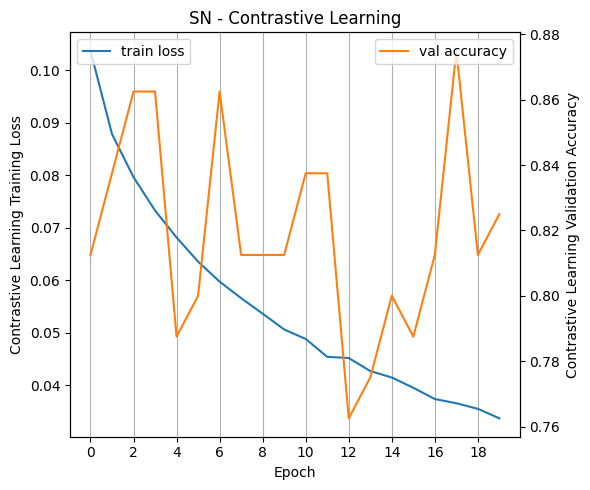

In [8]:
fig, ax = plt.subplots(1, figsize=(6, 5))

ax.plot(contrastive_history["train_loss"], label="train loss")
ax.set_title(f"{MODEL_NAME} - Contrastive Learning")
ax.set_ylabel("Contrastive Learning Training Loss")
ax.set_xlabel("Epoch")
ax.legend(loc="upper left")
ax.set_xticks(range(0, 21, 2))
ax.grid(True, axis='x')

ax_twin = ax.twinx()
ax_twin.plot(contrastive_history["val_acc"], label="val accuracy", color='tab:orange')
ax_twin.set_ylabel("Contrastive Learning Validation Accuracy")
ax_twin.legend(loc="upper right")

fig.tight_layout()

Displaying model performance on test set:

In [9]:
y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_closed_set", f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_closed_set", f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.753086,0.748969,0.746741,0.788235,0.795679,0.766667,0.753086


In [10]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.428571,0.750000,0.545455,4.000000
bigball,1.000000,0.800000,0.888889,5.000000
box,0.800000,1.000000,0.888889,4.000000
button,1.000000,0.833333,0.909091,6.000000
case,1.000000,0.800000,0.888889,5.000000
cube,1.000000,0.750000,0.857143,4.000000
cylinder,0.500000,0.200000,0.285714,5.000000
empty,1.000000,1.000000,1.000000,5.000000
jenga,0.500000,1.000000,0.666667,4.000000
labello,1.000000,0.400000,0.571429,5.000000


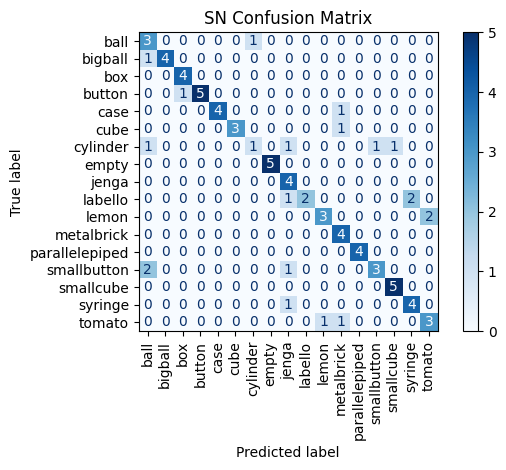

In [11]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_closed_set", f"{MODEL_NAME}_confusion_matrix.png")
)

**t-SNE of learned class embeddings across training, validation, and test splits**

<img src="./results/SN/SN_closed_set/embeddings_plot.png" style="width:100%;"/>

## 5-shot setting

Loading predictions and computing classification metrics:

In [12]:
_5_shot_dir = f"./results/{MODEL_NAME}/{MODEL_NAME}_5shot"

y_pred_query_full_5 = np.load(os.path.join(_5_shot_dir, f"{MODEL_NAME}_predictions_few_shot_full_ref.npy"))
y_pred_query_sub_5 = np.load(os.path.join(_5_shot_dir, f"{MODEL_NAME}_predictions_few_shot_sub_ref.npy"))
y_pred_query_new_5 = np.load(os.path.join(_5_shot_dir, f"{MODEL_NAME}_predictions_few_shot_new_ref.npy"))

_5_shot_data = np.load('./dataset/5shot_dataset.npz')
y_support_5 = _5_shot_data['y_support']
y_query_5 = _5_shot_data['y_query']

base_data = np.load('./dataset/base_dataset.npz')
y_base_test = base_data['y_test']

y_base_test_str = [y_mapping[label] for label in y_base_test]
y_support_5_str = [y_mapping[label] for label in y_support_5]
y_query_5_str = [y_mapping[label] for label in y_query_5]

base_test_labels = np.unique(y_base_test_str)
_5_support_labels = np.unique(y_support_5_str)
labels_5 = np.concatenate((base_test_labels, _5_support_labels))

y_pred_query_full_5_str = [y_mapping[label] for label in y_pred_query_full_5]
y_pred_query_sub_5_str = [y_mapping[label] for label in y_pred_query_sub_5]
y_pred_query_new_5_str = [y_mapping[label] for label in y_pred_query_new_5]

clf_scores_5s_df = pd.DataFrame()
clf_scores_5s_full_df, per_class_clf_scores_5s_full_df = get_clf_report_dfs(
    y_true=y_query_5_str, y_pred=y_pred_query_full_5_str
)
clf_scores_5s_sub_df, per_class_clf_scores_5s_sub_df = get_clf_report_dfs(
    y_true=y_query_5_str, y_pred=y_pred_query_sub_5_str
)
clf_scores_5s_new_df, per_class_clf_scores_5s_new_df = get_clf_report_dfs(
    y_true=y_query_5_str, y_pred=y_pred_query_new_5_str
)
clf_scores_5s_df = pd.concat([clf_scores_5s_full_df, clf_scores_5s_sub_df, clf_scores_5s_new_df], axis=0)
clf_scores_5s_df.index = ['Full Ref', 'Sub Ref', 'New Ref']

/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Displaying model performance:

In [13]:
print("Aggregated scores for new classes using different reference sets:")
display(clf_scores_5s_df.style.background_gradient(cmap="Blues"))
clf_scores_5s_df.to_csv(os.path.join(_5_shot_dir, f"{MODEL_NAME}_clf_scores.csv"))

Aggregated scores for new classes using different reference sets:


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
Full Ref,0.290476,0.126410,0.408923,0.298828,0.955804,0.089533,0.290476
Sub Ref,0.366667,0.155858,0.501406,0.286839,0.913621,0.113555,0.366667
New Ref,0.790476,0.791284,0.786153,0.796458,0.795877,0.800155,0.790476


In [14]:
print("Per class scores for new classes using all training data and the support set as reference set:")
display(per_class_clf_scores_5s_full_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:")
display(per_class_clf_scores_5s_sub_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using only the support set as reference set:")
display(per_class_clf_scores_5s_new_df[-5:].style.background_gradient(cmap="Blues"))


Per class scores for new classes using all training data and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,1.000000,0.228571,0.372093,35.000000
smallbutton,1.000000,0.265306,0.419355,49.000000
smallcube,0.875000,0.166667,0.280000,42.000000
syringe,0.906250,0.674419,0.773333,43.000000
tomato,1.000000,0.097561,0.177778,41.000000


Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,1.000000,0.285714,0.444444,35.000000
smallbutton,0.888889,0.326531,0.477612,49.000000
smallcube,0.818182,0.214286,0.339623,42.000000
syringe,0.882353,0.697674,0.779221,43.000000
tomato,1.000000,0.292683,0.452830,41.000000


Per class scores for new classes using only the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.809524,0.971429,0.883117,35.000000
smallbutton,0.829268,0.693878,0.755556,49.000000
smallcube,0.750000,0.571429,0.648649,42.000000
syringe,0.666667,0.837209,0.742268,43.000000
tomato,0.926829,0.926829,0.926829,41.000000


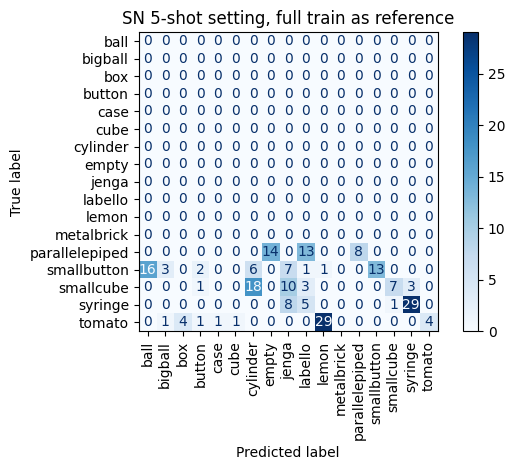

In [15]:
plot_confusion_matrix(
    y_true=y_query_5_str,
    y_pred=y_pred_query_full_5_str,
    title=f"{MODEL_NAME} 5-shot setting, full train as reference",
    path=os.path.join(_5_shot_dir, f"{MODEL_NAME}_confusion_matrix_full_ref.png"),
    labels=labels_5,
)

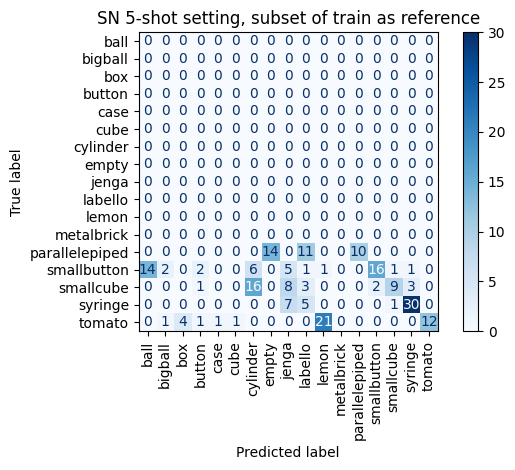

In [16]:
plot_confusion_matrix(
    y_true=y_query_5_str,
    y_pred=y_pred_query_sub_5_str,
    title=f"{MODEL_NAME} 5-shot setting, subset of train as reference",
    path=os.path.join(_5_shot_dir, f"{MODEL_NAME}_confusion_matrix_sub_ref.png"),
    labels=labels_5,
)

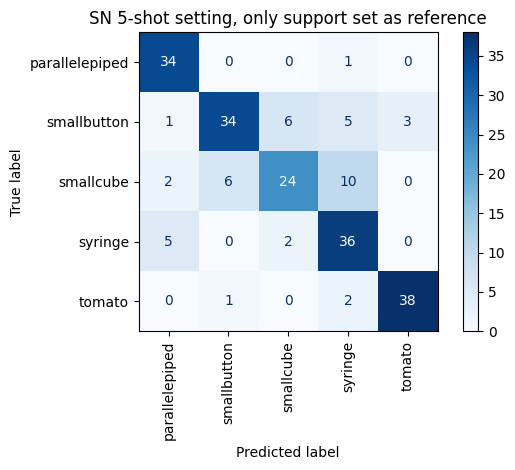

In [17]:
plot_confusion_matrix(
    y_true=y_query_5_str,
    y_pred=y_pred_query_new_5_str,
    title=f"{MODEL_NAME} 5-shot setting, only support set as reference",
    path=os.path.join(_5_shot_dir, f"{MODEL_NAME}_confusion_matrix_new_ref.png")
)

## 10-shot setting

Loading predictions and computing classification metrics:

In [18]:
_10_shot_dir = f"./results/{MODEL_NAME}/{MODEL_NAME}_10shot"

y_pred_query_full_10 = np.load(os.path.join(_10_shot_dir, f"{MODEL_NAME}_predictions_few_shot_full_ref.npy"))
y_pred_query_sub_10 = np.load(os.path.join(_10_shot_dir, f"{MODEL_NAME}_predictions_few_shot_sub_ref.npy"))
y_pred_query_new_10 = np.load(os.path.join(_10_shot_dir, f"{MODEL_NAME}_predictions_few_shot_new_ref.npy"))

_10_shot_data = np.load('./dataset/10shot_dataset.npz')
y_support_10 = _10_shot_data['y_support']
y_query_10 = _10_shot_data['y_query']

y_support_10_str = [y_mapping[label] for label in y_support_10]
y_query_10_str = [y_mapping[label] for label in y_query_10]

_10_support_labels = np.unique(y_support_10_str)
labels_10 = np.concatenate((base_test_labels, _10_support_labels))

y_pred_query_full_10_str = [y_mapping[label] for label in y_pred_query_full_10]
y_pred_query_sub_10_str = [y_mapping[label] for label in y_pred_query_sub_10]
y_pred_query_new_10_str = [y_mapping[label] for label in y_pred_query_new_10]

clf_scores_10s_df = pd.DataFrame()
clf_scores_10s_full_df, per_class_clf_scores_10s_full_df = get_clf_report_dfs(
    y_true=y_query_10_str, y_pred=y_pred_query_full_10_str
)
clf_scores_10s_sub_df, per_class_clf_scores_10s_sub_df = get_clf_report_dfs(
    y_true=y_query_10_str, y_pred=y_pred_query_sub_10_str
)
clf_scores_10s_new_df, per_class_clf_scores_10s_new_df = get_clf_report_dfs(
    y_true=y_query_10_str, y_pred=y_pred_query_new_10_str
)
clf_scores_10s_df = pd.concat([clf_scores_10s_full_df, clf_scores_10s_sub_df, clf_scores_10s_new_df], axis=0)
clf_scores_10s_df.index = ['Full Ref', 'Sub Ref', 'New Ref']

/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Displaying model performance:

In [19]:
print("Aggregated scores for new classes using different reference sets:")
display(clf_scores_10s_df.style.background_gradient(cmap="Blues"))
clf_scores_10s_df.to_csv(os.path.join(_10_shot_dir, f"{MODEL_NAME}_clf_scores.csv"))

Aggregated scores for new classes using different reference sets:


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
Full Ref,0.427027,0.190487,0.557227,0.306569,0.917325,0.147199,0.427027
Sub Ref,0.481081,0.207921,0.609293,0.297154,0.884410,0.165181,0.481081
New Ref,0.837838,0.836266,0.830519,0.840945,0.841129,0.849009,0.837838


In [20]:
print("Per class scores for new classes using all training data and the support set as reference set:")
display(per_class_clf_scores_10s_full_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:")
display(per_class_clf_scores_10s_sub_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using only the support set as reference set:")
display(per_class_clf_scores_10s_new_df[-5:].style.background_gradient(cmap="Blues"))


Per class scores for new classes using all training data and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.952381,0.666667,0.784314,30.000000
smallbutton,0.909091,0.227273,0.363636,44.000000
smallcube,0.875000,0.378378,0.528302,37.000000
syringe,0.862069,0.657895,0.746269,38.000000
tomato,1.000000,0.277778,0.434783,36.000000


Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.952381,0.666667,0.784314,30.000000
smallbutton,0.785714,0.250000,0.379310,44.000000
smallcube,0.857143,0.486486,0.620690,37.000000
syringe,0.862069,0.657895,0.746269,38.000000
tomato,1.000000,0.416667,0.588235,36.000000


Per class scores for new classes using only the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.857143,1.000000,0.923077,30.000000
smallbutton,0.885714,0.704545,0.784810,44.000000
smallcube,0.785714,0.594595,0.676923,37.000000
syringe,0.755102,0.973684,0.850575,38.000000
tomato,0.921053,0.972222,0.945946,36.000000


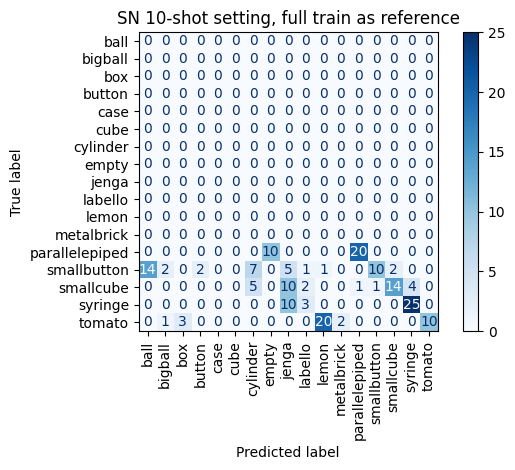

In [21]:
plot_confusion_matrix(
    y_true=y_query_10_str,
    y_pred=y_pred_query_full_10_str,
    title=f"{MODEL_NAME} 10-shot setting, full train as reference",
    path=os.path.join(_10_shot_dir, f"{MODEL_NAME}_confusion_matrix_full_ref.png"),
    labels=labels_10,
)

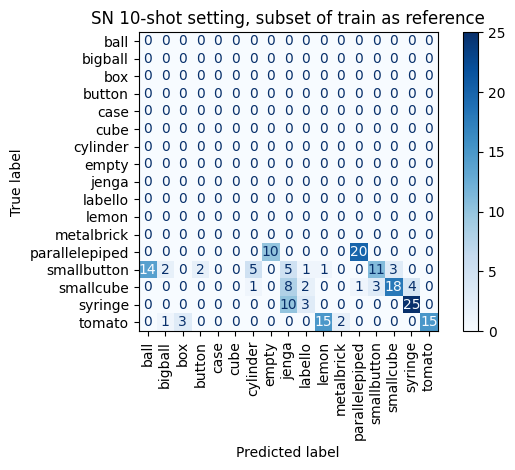

In [22]:
plot_confusion_matrix(
    y_true=y_query_10_str,
    y_pred=y_pred_query_sub_10_str,
    title=f"{MODEL_NAME} 10-shot setting, subset of train as reference",
    path=os.path.join(_10_shot_dir, f"{MODEL_NAME}_confusion_matrix_sub_ref.png"),
    labels=labels_10,
)

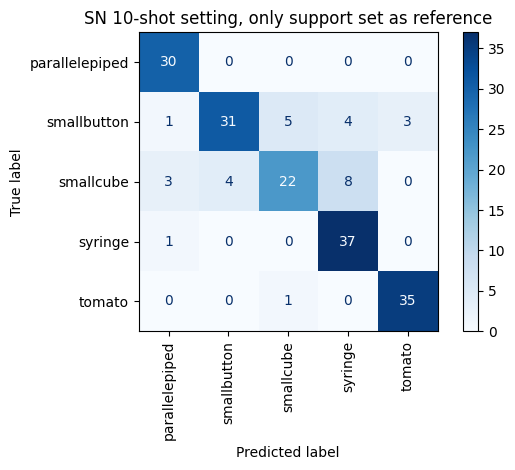

In [23]:
plot_confusion_matrix(
    y_true=y_query_10_str,
    y_pred=y_pred_query_new_10_str,
    title=f"{MODEL_NAME} 10-shot setting, only support set as reference",
    path=os.path.join(_10_shot_dir, f"{MODEL_NAME}_confusion_matrix_new_ref.png")
)

**t-SNE of class embeddings for learned and novel classes**

<img src="./results/SN/SN_10shot/embeddings_plot.png" style="width:50%;"/>